link menuju Dataset : https://morgenm.github.io/blog/2023/phishing-detection-ai/ 

In [ ]:
import mailbox
import gensim
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import *
import eml_parser, json, datetime
import email
import pandas as pd
import numpy as np
import os
import joblib
import nltk
nltk.download("stopwords")
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tf
from tensorflow.keras import layers

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data preprocessing

## Extracting the body text

In [ ]:
def get_charsets(msg):
    charsets = set({})
    for c in msg.get_charsets():
        if c is not None:
            charsets.update([c])
    return charsets
def handle_error(errmsg, emailmsg,cs):
    '''print()
    print(errmsg)
    print("This error occurred while decoding with ",cs," charset.")
    print("These charsets were found in the one email.",get_charsets(emailmsg))
    print("This is the subject:",emailmsg['subject'])
    print("This is the sender:",emailmsg['From'])'''
    pass
def get_body_from_email(msg):
    body = None
    #Walk through the parts of the email to find the text body.    
    if msg.is_multipart():    
        for part in msg.walk():

            # If part is multipart, walk through the subparts.            
            if part.is_multipart(): 

                for subpart in part.walk():
                    if subpart.get_content_type() == 'text/plain':
                        # Get the subpart payload (i.e the message body)
                        body = subpart.get_payload(decode=True) 
                        charset = subpart.get_charset()
            # Part isn't multipart so get the email body
            elif part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True)
                charset = part.get_charset()
    # If this isn't a multi-part message then get the payload (i.e the message body)
    elif msg.get_content_type() == 'text/plain':
        body = msg.get_payload(decode=True) 
    # Uncomment this to also include html and other formats
    else:
        body = msg.get_payload(decode=True) 
    return body

### Phishing emails

In [8]:
import os
import mailbox

# List file yang akan dibuka
phishingBoxFilenames = [
    # r".\\Dataset\\Filedata\\phishing3.mbox",
    # r".\\Dataset\\Filedata\\phishing2.mbox",
    # r".\\Dataset\\Filedata\\phishing1.mbox",
    #  r".\\Dataset\\Filedata\\phishing0.mbox",
    # r"./Dataset/Filedata/phishing2022.mbox",
    # r"./Dataset/Filedata/phishing2021.mbox",
    # r"./Dataset/Filedata/phishing2020.mbox",
    # r"./Dataset/Filedata/phishing2019.mbox",
    # r"./Dataset/Filedata/phishing2018.mbox",
    # r"./Dataset/Filedata/phishing2017.mbox",
    # r"./Dataset/Filedata/phishing2016.mbox",
    # r"./Dataset/Filedata/phishing2015.mbox"
]
phishingBoxes = [mailbox.mbox(f) for f in phishingBoxFilenames]
phishingMessages = [m[1] for phishingBox in phishingBoxes for m in phishingBox.items()]

phishingMessageBodies = []
for p in phishingMessages:
    body = get_body_from_email(p)
    if body is not None and len(body) > 0:
        phishingMessageBodies.append(body)
        
print(len(phishingMessages), len(phishingMessageBodies))


0 0


In [9]:
phishingBoxFilenames = ["./Dataset/Filedata/phishing3.mbox",
                        "./Dataset/Filedata/phishing1.mbox", 
                        "./Dataset/Filedata/phishing0.mbox",
                       "./Dataset/Filedata/phishing-2017.mbox", 
                       "./Dataset/Filedata/phishing-2016.mbox", 
                       "./Dataset/Filedata/phishing-2015.mbox"]
phishingBoxes = [mailbox.mbox(f) for f in phishingBoxFilenames]
phishingMessages = [m[1] for phishingBox in phishingBoxes for m in phishingBox.items()]

phishingMessageBodies = []
for p in phishingMessages:
    body = get_body_from_email(p)
    if body is not None and len(body) > 0:
        phishingMessageBodies.append(body)
        
print(len(phishingMessages), len(phishingMessageBodies))

1126 954


In [10]:
print (len(phishingMessages) - len(phishingMessageBodies))

172


In [11]:
import os
print(os.path.exists("fradulent_emails.txt"))  # Harus True jika file ada


True


In [12]:
# Clair Fraud Email Database 
#Kumpulan data ini merupakan kumpulan lebih dari 2.500 Surat Penipuan "Nigeria", yang berasal dari tahun 1998 hingga 2007.
added = [] #lisk kosong untuk menyimpan body email.
with open("fradulent_emails.txt", 'r', errors="ignore") as f:
    body = ""
    inBody = False
    for line in f:
        if line.startswith("Status: O"):
            inBody = True
        
        elif line.startswith("From r") and len(body) > 0:
            inBody = False
            added.append(body)
            body = ""

        elif inBody:
            body += line

phishingMessageBodies = list(set(phishingMessageBodies + [a for a in added if len(a) > 0]))
print(len(phishingMessageBodies)) #yang berhasil diekstraksi
    

2058


In [13]:
# Inisialisasi parser email
#SpamAssassin Public Corpus adalah dataset email yang digunakan untuk menguji dan melatih 
# model deteksi spam. Dataset ini berisi email spam dan non-spam (ham) 
# yang dikumpulkan oleh komunitas open-source dan digunakan dalam pengembangan SpamAssassin
ep = eml_parser.EmlParser(include_raw_body=True)

# Direktori dataset email spam
spamDir = "./dataset/2/spam_2/"
spamFilenames = [os.path.join(spamDir, f) for f in os.listdir(spamDir) if f.endswith(".eml")]

# List untuk menyimpan email spam yang telah diproses
added = []

for filename in spamFilenames:
    try:
        # Membuka file dalam mode biner (rb)
        with open(filename, "rb") as f:
            b = f.read()
        
        # Coba parsing menggunakan email parser bawaan
        msg = message_from_bytes(b, policy=default)
        
        # Pastikan email memiliki body sebelum diproses
        if msg.is_multipart():
            body = ""
            for part in msg.walk():
                # Hanya ambil bagian teks biasa (bukan attachment)
                if part.get_content_type() == "text/plain":
                    body += part.get_payload(decode=True).decode(part.get_content_charset() or "utf-8", errors="ignore")
        else:
            body = msg.get_payload(decode=True).decode(msg.get_content_charset() or "utf-8", errors="ignore")
        
        if body.strip():  # Pastikan body tidak kosong
            added.append(body)

    except Exception as e:
        print(f"Error membaca email {filename}: {e}")

# Gabungkan dengan phishingMessageBodies, hilangkan duplikasi
try:
    phishingMessageBodies = list(set(phishingMessageBodies + added))
except NameError:
    phishingMessageBodies = list(set(added))  # Jika phishingMessageBodies belum ada

# Tampilkan jumlah total email yang telah diproses
print(f"Total email phishing yang diproses: {len(phishingMessageBodies)}")


Total email phishing yang diproses: 2058


In [14]:
# # SpamAssassin Spam (not exactly phishing, but NVIDIA article used it as phishing so attempting it)
# ep = eml_parser.EmlParser(include_raw_body=True)

# spamDir = "./dataset/2/spam_2/"
# spamFilenames = [os.path.join(spamDir, f) for f in os.listdir(spamDir)]

# added = []
# for filename in spamFilenames:
#     with open(filename, "rb") as f:
#         b = f.read()
    
#     m = ep.decode_email_bytes(b)
#     if len(m["body"]) >= 1:
#         added.append(m["body"][0]["content"])
    
# phishingMessageBodies = list(set(phishingMessageBodies + added))
# print(len(phishingMessageBodies))

### Benign emails

Benign emails dalam konteks ini merujuk pada email yang tidak berbahaya, yaitu bukan spam, phishing, atau email berbahaya lainnya.

In [ ]:
import os  # Modul untuk operasi file dan direktori
import eml_parser  # Modul untuk parsing file email (.eml)
# Inisialisasi parser email dengan menyertakan isi body mentah
ep = eml_parser.EmlParser(include_raw_body=True)
# Menentukan direktori tempat menyimpan email non-spam (ham)
easyHamDir = "./dataset/2/easy_ham/"  # Folder email mudah diklasifikasikan sebagai non-spam
hardHamDir = "./dataset/2/hard_ham/hard_ham"  # Folder email yang lebih sulit diklasifikasikan

# Mengambil daftar semua file email dari kedua folder
easyHamFiles = [os.path.join(easyHamDir, f) for f in os.listdir(easyHamDir)]  # File dari easy_ham
hardHamFiles = [os.path.join(hardHamDir, f) for f in os.listdir(hardHamDir)]  # File dari hard_ham
hamFilenames = easyHamFiles + hardHamFiles  # Gabungkan semua file email ke dalam satu list

# List untuk menyimpan isi email yang berhasil diekstrak
benignMessageBodies = []

# Iterasi melalui setiap file email untuk membaca isinya
for filename in hamFilenames:
    with open(filename, "rb") as f:  # Buka file dalam mode biner (rb)
        b = f.read()  # Baca seluruh isi file email
    
    m = ep.decode_email_bytes(b)  # Parsing isi email dengan eml_parser
    
    if len(m["body"]) >= 1:  # Periksa apakah email memiliki isi
        benignMessageBodies.append(m["body"][0]["content"])  # Simpan isi email ke dalam list

# Menampilkan jumlah email yang berhasil diekstrak
print(f"Jumlah email phising yang diproses: {len(benignMessageBodies)}")

Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.
Header field "message-id" is in an invalid format and cannot be fixed, it will be dropped.

Jumlah email phising yang diproses: 2801


In [16]:
# benign emails
personalBox = mailbox.mbox("./Dataset/Filedata/benign.mbox")
personalMessages = [m[1] for m in personalBox.items()][:len(phishingMessageBodies)//3] # limit amount added

added = []
for p in personalMessages:
    body = get_body_from_email(p)
    if body is not None and len(body) > 0:
        added.append(body)

benignMessageBodies += added
print(len(benignMessageBodies))

2801


In [17]:
enronMailDir = "./Dataset/2/emails.csv/"

enronMessages = []
for directory, subdir, filenames in os.walk(enronMailDir):
    for filename in filenames:
        with open(os.path.join(directory, filename), "rb") as f:
            m = email.parser.Parser().parsestr(f.read().decode("utf-8", errors="ignore"))
            enronMessages.append(m)

added = []
for m in enronMessages:
    body = get_body_from_email(m)
    if body is not None and len(body) > 0:
        added.append(body)

# limit the amount added, so that benign is not >> phishing
if len(added) + len(benignMessageBodies) > len(phishingMessageBodies):
    toAdd = round((1.1 * len(phishingMessageBodies)) - len(benignMessageBodies))
    print(toAdd)
    added = added[:toAdd]

benignMessageBodies += added
print(len(benignMessageBodies))

-537
2801


## Simple preprocessing

Kode ini mendefinisikan daftar **stop words** khusus dengan menambahkan kata-kata tambahan seperti "font", "arial", dan "http" ke dalam daftar **stopwords bahasa Inggris** dari NLTK. Selain itu, kode ini membuat daftar **CUSTOM_FILTERS** yang berisi berbagai fungsi pemrosesan teks, seperti mengubah teks menjadi huruf kecil, menghapus tag HTML, tanda baca, angka, kata pendek, serta melakukan stemming.

In [18]:
# Custom stop words and preprocessing filters

stopWords = nltk.corpus.stopwords
stopWords = stopWords.words("english")
stopWords.extend(["nbsp", "font", "sans", "serif", "bold", "arial", "verdana", "helvetica", "http", "https", "www", "html", "enron", "margin", "spamassassin"])

def remove_custom_stopwords(p):
    return remove_stopwords(p, stopwords=stopWords)

CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_custom_stopwords, remove_stopwords, strip_short, stem_text]

Kode ini memastikan bahwa semua pesan phishing dan pesan non-phishing (benign) dikonversi ke format **UTF-8**, mengabaikan karakter yang tidak dapat dikodekan. Jika pesan sudah dalam bentuk string, kode tetap menyimpannya tanpa perubahan; jika masih dalam bentuk **byte**, kode akan mendekodenya sebelum menyimpannya kembali.

In [19]:
# Decode to utf-8 as needed

# Phishing
phishingDecoded = []
for b in phishingMessageBodies:
    try:
        p = b.decode("utf-8", errors="ignore")
    except AttributeError:
        p = b
    phishingDecoded.append(p)
phishingMessageBodies = phishingDecoded

# Benign
benignDecoded = []
for b in benignMessageBodies:
    try:
        p = b.decode("utf-8", errors="ignore")
    except AttributeError:
        p = b
    benignDecoded.append(p)
benignMessageBodies = benignDecoded

Kode ini melakukan **preprocessing** pada setiap pesan phishing dengan menerapkan **CUSTOM_FILTERS** (seperti menghapus tag HTML, tanda baca, angka, dan stopwords), lalu menyimpan hasilnya dalam **phishingPreprocessed** dan mencetak jumlah pesan yang telah diproses.

In [20]:
# Phishing emails
phishingPreprocessed = []
for b in phishingMessageBodies:
    p = preprocess_string(b, filters=CUSTOM_FILTERS)
    #p = gensim.parsing.preprocessing.remove_stopwords(p, stopwords=stopWords
    
    phishingPreprocessed.append(p)
print(len(phishingPreprocessed))

2058


Kode ini melakukan **preprocessing** pada setiap email benign (tidak berbahaya) dengan menerapkan **CUSTOM_FILTERS**, menyimpannya dalam **benignPreprocessed**, lalu mencetak jumlah email yang telah diproses.

In [21]:
# Benign emails
benignPreprocessed = []
for b in benignMessageBodies:
    p = preprocess_string(b, filters=CUSTOM_FILTERS)
    benignPreprocessed.append(p)
print(len(benignPreprocessed))

2801


# Word2vec

Kode ini melatih model **Word2Vec** menggunakan kombinasi email phishing dan benign yang telah diproses, dengan parameter **min_count=1** (memasukkan semua kata), **workers=3** (menggunakan 3 thread), dan **window=5** (konteks kata dalam jendela 5 kata).

In [22]:
# Train the model on all messages
model = Word2Vec(phishingPreprocessed + benignPreprocessed, min_count=1, workers=3, window=5)

In [23]:
model.wv.most_similar("dollar", topn=20) #berfungsi untuk mencari 20 kata terdekat (top 20) yang memiliki kemiripan 
#paling tinggi dengan kata "dollar" berdasarkan vektor yang telah dipelajari oleh model Word2Vec.

[('million', 0.9444568753242493),
 ('usd', 0.928344190120697),
 ('thousand', 0.9261074066162109),
 ('sterl', 0.8861516714096069),
 ('pound', 0.8859230279922485),
 ('emillion', 0.8849160671234131),
 ('quadrupl', 0.8806381225585938),
 ('usand', 0.8751312494277954),
 ('ten', 0.8716148138046265),
 ('unit', 0.8705044984817505),
 ('hundr', 0.8678447008132935),
 ('cent', 0.863131046295166),
 ('billion', 0.8569457530975342),
 ('gbp', 0.8532580733299255),
 ('musd', 0.8526546359062195),
 ('thirti', 0.8439661860466003),
 ('pluri', 0.8423023819923401),
 ('millio', 0.8341809511184692),
 ('eighti', 0.8310294151306152),
 ('alberta', 0.8287742733955383)]

In [24]:
model.wv["dollar"] #berfungsi untuk mengambil vektor representasi dari kata "dollar" yang telah dipelajari oleh model Word2Vec.
#sehingga bisa pula dianalisis kesamaan kata dalam bentuk ruang vektor. 

array([ 0.35240662, -1.3544906 , -0.6218965 ,  2.0662963 , -4.363752  ,
       -0.88635635,  0.21246766,  2.2610452 , -2.6731613 ,  1.0315464 ,
       -0.6672979 , -1.4732038 , -1.3625172 ,  1.8528852 , -0.9117037 ,
       -1.8023411 , -2.345138  , -4.254357  , -0.09258556,  2.0395246 ,
        2.4190142 , -0.03953606,  0.49211314,  0.3262317 , -1.2204    ,
        1.1797725 , -2.3290803 , -0.10240281, -0.75749123,  1.754399  ,
        3.6173077 ,  1.5498375 ,  2.7696517 , -2.284378  , -1.7882714 ,
       -0.96637404, -0.1558994 ,  1.3956698 , -1.6705244 , -2.3201787 ,
        0.5892924 , -0.5166844 , -0.55819106,  1.7256519 , -0.3706958 ,
       -1.7474704 ,  0.1581548 , -1.2485734 ,  0.66454387, -0.81454736,
       -2.2466142 , -0.5343416 ,  2.6672046 , -1.4467741 , -0.81949574,
       -0.14126731, -0.5600987 ,  1.9260886 , -1.0704443 , -1.0818298 ,
        1.7824441 ,  1.9812994 , -1.1482811 , -1.1934271 , -2.596242  ,
       -0.19234312, -0.71702254,  2.7962072 , -3.522401  , -1.43

# Wordcloud

## Both

Tujuannya adalah untuk membuat satu string besar yang berisi semua kata dari dataset, sehingga dapat digunakan untuk visualisasi seperti **WordCloud** .

In [25]:
# Gabungkan semua dokumen menjadi satu string besar, pisahkan kata dengan koma
cloudString = ','.join([' '.join(doc) for doc in phishingPreprocessed + benignPreprocessed])

# Alternatif untuk memastikan format string aman
cloudString = ', '.join(map(lambda doc: ' '.join(doc), phishingPreprocessed + benignPreprocessed))


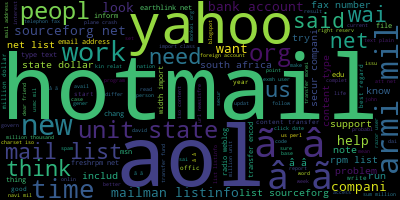

In [26]:
#Kode ini membuat word cloud dengan maksimal 5000 kata dan latar belakang hitam. Word cloud dihasilkan dari teks dalam `cloudString`, 
# di mana kata yang lebih sering muncul akan ditampilkan lebih besar. Hasilnya dikonversi menjadi gambar untuk ditampilkan atau disimpan.
wordCloud = WordCloud(max_words=5000, background_color="black")
wordCloud.generate(cloudString)
wordCloud.to_image()

# LDA Topic Modeling

LDA (Latent Dirichlet Allocation) adalah teknik pemodelan topik yang digunakan untuk menemukan kelompok kata yang sering muncul bersama dalam dokumen, sehingga dapat mengidentifikasi topik tersembunyi dalam kumpulan teks.

Kode `numTopics = 1024` menetapkan jumlah topik dalam pemodelan topik, seperti LDA (Latent Dirichlet Allocation). Nilai 1024 menunjukkan bahwa model akan mencoba menemukan 1024 topik berbeda dalam kumpulan data. Pemilihan jumlah topik ini bergantung pada kompleksitas dan ukuran data yang dianalisis.

In [27]:
numTopics = 1024

## Both

Kode ini membuat kamus (dictionary) dari kata-kata dalam email phishing dan non-phishing, lalu mengonversi setiap email menjadi representasi bag-of-words (corpus) berdasarkan frekuensi term dalam dokumen.

In [28]:
# Create dictionary and corpus
dictionary = gensim.corpora.Dictionary(phishingPreprocessed + benignPreprocessed)
corpus = [dictionary.doc2bow(text) for text in phishingPreprocessed + benignPreprocessed] # Term document frequency

Kode ini menyimpan objek dictionary yang telah dibuat menggunakan **joblib** ke dalam file **ldaDictionary.joblib**, sehingga bisa digunakan kembali tanpa perlu membuat ulang.

In [29]:
joblib.dump(dictionary, "./DatasetNew/ldaDictionary.joblib")

['./DatasetNew/ldaDictionary.joblib']

Kode ini membuat model **LDA (Latent Dirichlet Allocation)** menggunakan **Gensim** untuk menemukan topik dalam data, dengan mencoba **LdaMulticore** terlebih dahulu untuk pemrosesan lebih cepat, dan jika terjadi **OSError**, maka akan menggunakan **LdaModel** biasa. Model ini akan mengelompokkan teks ke dalam maksimal 50 topik (atau sesuai ukuran **dictionary**) dengan beberapa parameter seperti jumlah **workers**, **chunksize**, dan jumlah **passes** untuk meningkatkan akurasi.

In [30]:
import gensim
import gensim.corpora as corpora

# Pastikan dictionary & corpus sudah dibuat
if not dictionary or not corpus:
    raise ValueError("Dictionary atau Corpus kosong. Pastikan telah diproses dengan benar.")

# Batasi jumlah topik jika dataset kecil
numTopics = min(len(dictionary), 50)  # Misalnya, maksimal 50 topik

try:
    # Coba pakai LdaMulticore
    ldaModel = gensim.models.LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=numTopics,
        workers=4,  
        chunksize=2000,
        passes=10,
        per_word_topics=True
    )
except OSError:
    print("OSError")
    ldaModel = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=numTopics,
        chunksize=2000,
        passes=10,
        per_word_topics=True
    )

print("Model LDA berhasil dibuat dengan", numTopics, "topik.")


Model LDA berhasil dibuat dengan 50 topik.


In [31]:
# Create model
ldaModel = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=numTopics)

Kode ini mencetak daftar topik yang dihasilkan oleh model **LDA**, di mana setiap topik berisi sekumpulan kata-kata dengan bobot probabilitasnya. **print_topics()** digunakan untuk melihat representasi topik yang telah dipelajari oleh model.

In [33]:
print(ldaModel.print_topics())

[(49, '0.009*"com" + 0.005*"email" + 0.005*"monei" + 0.005*"content" + 0.004*"mail" + 0.003*"compani" + 0.003*"import" + 0.003*"us" + 0.003*"new" + 0.003*"secur"'), (39, '0.033*"com" + 0.009*"net" + 0.008*"account" + 0.007*"bank" + 0.005*"compani" + 0.005*"list" + 0.005*"hotmail" + 0.005*"transfer" + 0.004*"monei" + 0.004*"fund"'), (11, '0.046*"com" + 0.011*"hotmail" + 0.010*"net" + 0.010*"aol" + 0.007*"yahoo" + 0.007*"mail" + 0.005*"org" + 0.004*"mil" + 0.003*"messag" + 0.003*"secur"'), (31, '0.021*"list" + 0.013*"email" + 0.013*"com" + 0.013*"mail" + 0.009*"account" + 0.009*"net" + 0.008*"sourceforg" + 0.007*"razor" + 0.007*"monei" + 0.006*"bank"'), (2, '0.020*"com" + 0.009*"net" + 0.007*"account" + 0.005*"hotmail" + 0.005*"rpm" + 0.005*"yahoo" + 0.005*"aol" + 0.005*"list" + 0.004*"monei" + 0.004*"bank"'), (23, '0.053*"com" + 0.013*"hotmail" + 0.013*"aol" + 0.010*"net" + 0.007*"yahoo" + 0.006*"mil" + 0.004*"busi" + 0.004*"secur" + 0.003*"compani" + 0.003*"new"'), (41, '0.016*"com" + 

Kode ini menyimpan model **LDA** yang telah dilatih ke dalam file `ldaModel.joblib` di folder `DatasetNew`, sehingga model dapat dimuat kembali tanpa perlu dilatih ulang.

In [34]:
joblib.dump(ldaModel, "./DatasetNew/ldaModel.joblib")

['./DatasetNew/ldaModel.joblib']

Kode ini digunakan untuk memvisualisasikan hasil pemodelan **LDA** menggunakan **pyLDAvis**. Model LDA yang telah dibuat diproses dengan **pyLDAvis.gensim.prepare** agar bisa divisualisasikan dalam bentuk interaktif. Hasil visualisasi kemudian disimpan dalam file **HTML** dan juga ditampilkan langsung di **notebook**.

In [35]:
import pyLDAvis
import pyLDAvis.gensim
import gc  # Garbage Collector untuk membersihkan memori yang tidak terpakai
from joblib import parallel_backend

# # Gunakan backend joblib yang lebih hemat memori
# with parallel_backend('loky', inner_max_num_threads=1):
ldavis = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)

# Simpan hasil visualisasi ke dalam file HTML
os.makedirs("./Model", exist_ok=True)  # Pastikan folder "Model" ada
pyLDAvis.save_html(ldavis, "./Model/ldavis_both.html")

# Tampilkan visualisasi di notebook
pyLDAvis.enable_notebook()
ldavis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
20    -0.219154  0.008616       1        1  16.356013
46     0.099299  0.056273       2        1   7.098810
30     0.079506  0.016884       3        1   6.789498
28     0.049156 -0.054489       4        1   5.548550
38     0.047290 -0.065612       5        1   5.374916
37     0.087705  0.057672       6        1   5.082028
45     0.032819  0.051248       7        1   3.924252
3      0.069263  0.031973       8        1   3.353508
34     0.057159  0.046537       9        1   3.252526
0     -0.028255 -0.041662      10        1   3.220029
10     0.046570  0.006476      11        1   3.190041
29    -0.034772 -0.011493      12        1   2.847670
31     0.052903 -0.025732      13        1   2.474887
17    -0.006566 -0.023352      14        1   2.362534
21     0.030390 -0.063488      15        1   2.222781
33     0.049189  0.029324      16        1   2.093486
44    -0.070248  0.010687      17        1   1.886003
4     -0.012175 -0.009706      18        1   1.870129
32     0.045743  0.038722      19        1   1.593057
43     0.047674 -0.024785      20        1   1.366187
48     0.034962 -0.030658      21        1   1.137952
36     0.035610 -0.030250      22        1   1.119027
41     0.024854 -0.001745      23        1   1.102319
8      0.006018 -0.058692      24        1   1.035955
19     0.053111 -0.030022      25        1   0.967224
18    -0.022123  0.021500      26        1   0.964632
39    -0.005240  0.021472      27        1   0.949499
5      0.035160  0.014451      28        1   0.868446
27     0.000869  0.041620      29        1   0.804914
47    -0.052079 -0.076278      30        1   0.800989
22     0.005940  0.002423      31        1   0.782647
24     0.028611 -0.059899      32        1   0.699046
14    -0.036290  0.003879      33        1   0.682651
1      0.027971  0.017472      34        1   0.650089
40     0.016572 -0.048794      35        1   0.632300
16     0.036199 -0.004127      36        1   0.588607
15     0.006340  0.011259      37        1   0.472572
26    -0.074533  0.032878      38        1   0.451377
23    -0.057713  0.007166      39        1   0.409521
13    -0.013920  0.043586      40        1   0.396164
6      0.017706 -0.024631      41        1   0.393646
11    -0.062484 -0.012511      42        1   0.367739
2     -0.006415  0.012401      43        1   0.366410
35     0.024761 -0.010017      44        1   0.331899
49     0.012851 -0.016520      45        1   0.331000
25    -0.097767  0.052663      46        1   0.302827
42     0.029528  0.053782      47        1   0.174519
12    -0.047525  0.011928      48        1   0.138045
7     -0.211015 -0.027141      49        1   0.107958
9     -0.133453  0.048713      50        1   0.063120, topic_info=           Term          Freq         Total Category  logprob  loglift
183         com  36476.000000  36476.000000  Default  30.0000  30.0000
96      hotmail   6094.000000   6094.000000  Default  29.0000  29.0000
14525       aol   5032.000000   5032.000000  Default  28.0000  28.0000
1595        net   6997.000000   6997.000000  Default  27.0000  27.0000
251       yahoo   5101.000000   5101.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
85       famili      0.931968   1524.911398  Topic50  -6.4014  -0.0323
3589       list      1.217341   3644.357612  Topic50  -6.1343  -0.6364
28     transact      1.016975   2211.831963  Topic50  -6.3141  -0.3168
546        help      0.848437   1469.535834  Topic50  -6.4953  -0.0892
54      contact      0.813929   2127.105516  Topic50  -6.5368  -0.5005

[4063 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
6000       1  0.521881      aaf
6000      22  0.260940      aaf
49309      5  0.515223      aap
49309     23  0.085870      aap
49309     25  0.171741      aap
...      ...       ...      ...
462

Visualisasi ini menunjukkan hasil pemodelan **LDA** dengan **pyLDAvis**, di mana grafik kiri (Intertopic Distance Map) menggambarkan hubungan antar-topik dalam bentuk distribusi dua dimensi menggunakan multidimensional scaling (MDS). Setiap lingkaran mewakili satu topik, dengan ukuran yang mencerminkan proporsi relatif dari topik tersebut dalam korpus, sementara posisi menunjukkan perbedaan atau kesamaan antar-topik. Grafik kanan (Top-30 Most Salient Terms) menampilkan 30 kata paling menonjol dalam korpus, dengan panjang batang menunjukkan frekuensi keseluruhan kata tersebut dan warna merah menunjukkan estimasi frekuensi dalam topik tertentu.

## Phishing

Kode ini membuat **kamus (dictionary)** dari kata-kata dalam email phishing menggunakan `gensim.corpora.Dictionary`, yang berisi daftar unik dari semua kata dalam dataset phishing. Kemudian, kode mengonversi setiap email phishing menjadi representasi **bag-of-words (BoW)** dalam bentuk **corpus**, di mana setiap dokumen direpresentasikan sebagai daftar pasangan `(id_kata, frekuensi)`.

In [36]:
# Create dictionary and corpus
dictionaryPhishing= gensim.corpora.Dictionary(phishingPreprocessed)
corpusPhishing = [dictionaryPhishing.doc2bow(text) for text in phishingPreprocessed] # Term document frequency'''

In [37]:
# Create model
ldaModelPhishing = gensim.models.LdaMulticore(corpus=corpusPhishing, id2word=dictionaryPhishing, num_topics=numTopics)

In [39]:
import os
import pyLDAvis
import pyLDAvis.gensim

def visualize_lda(lda_model, corpus, dictionary, output_file="ldavis_phishing.html"):
    """
    Fungsi untuk membuat visualisasi LDA dan menyimpannya dalam file HTML.
    """
    print("Membuat visualisasi LDA...")
    ldavis_phishing = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    
    # Simpan hasil visualisasi
    pyLDAvis.save_html(ldavis_phishing, output_file)
    print(f"Visualisasi LDA disimpan sebagai {output_file}")

# Contoh pemanggilan fungsi jika model sudah ada
visualize_lda(ldaModelPhishing, corpusPhishing, dictionaryPhishing)

Membuat visualisasi LDA...
Visualisasi LDA disimpan sebagai ldavis_phishing.html


In [38]:
# Visualize LDA
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

ldavisPhishing = pyLDAvis.gensim.prepare(ldaModelPhishing, corpusPhishing, dictionaryPhishing)
pyLDAvis.save_html(ldavisPhishing, "./Model/ldavis_phishing.html")
#ldavisPhishing

## Benign

In [40]:
# Create dictionary and corpus
dictionaryBenign = gensim.corpora.Dictionary(benignPreprocessed)
corpusBenign = [dictionaryBenign.doc2bow(text) for text in benignPreprocessed] # Term document frequency

In [42]:
# Create model
ldaModelBenign = gensim.models.LdaMulticore(corpus=corpusBenign, id2word=dictionaryBenign, num_topics=numTopics)

In [43]:
# Visualize LDA
pyLDAvis.enable_notebook()

ldavisBenign = pyLDAvis.gensim.prepare(ldaModelBenign, corpusBenign, dictionaryBenign)
pyLDAvis.save_html(ldavisBenign, "./Model/ldavis_benign.html")
#ldavisBenign

# Doc2Vec

In [44]:
taggedDocs = [TaggedDocument(doc, [i]) for i, doc in enumerate(phishingPreprocessed + benignPreprocessed)]

In [45]:
doc2VecModel = Doc2Vec(taggedDocs, vector_size=20, window=2, min_count=1, workers=4)

In [47]:
joblib.dump(doc2VecModel, "./DatasetNew/doc2VecModel.joblib")

['./DatasetNew/doc2VecModel.joblib']

# Classification

In [48]:
allPreprocessed = phishingPreprocessed + benignPreprocessed
allBodies = phishingMessageBodies + benignMessageBodies

In [49]:
# Blacklisted words and phrases pulled form spam wordlist
# Will be a list of lists. Each phrase/words is a list of preprocessed words If a given email has all of the stemmed/preprocessed words in a given list, it's a hit.

blackListWords = []
with open("spam_wordlist.txt", 'r') as f:
    for line in f:
        blackListWords.append(line)

blackList = []
for b in blackListWords:
    blackListEntry = preprocess_string(b, filters=CUSTOM_FILTERS)
    if len(blackListEntry) > 0 and blackListEntry not in blackList:
        blackList.append(blackListEntry)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF for the top set amount of words
maximumTermCount = 6

def preprocessor_func(s):
    sentence = " ".join(preprocess_string(s, filters=CUSTOM_FILTERS))
    return sentence

tfIDFVectorizer = TfidfVectorizer(max_features=maximumTermCount, preprocessor=preprocessor_func, sublinear_tf=True)
tfIDF = tfIDFVectorizer.fit_transform(allBodies).toarray()
# print(tfIDFVectorizer.get_feature_names())
print(tfIDFVectorizer.get_feature_names_out())
print(tfIDF.shape)

['account' 'aol' 'com' 'hotmail' 'net' 'yahoo']
(4859, 6)


In [51]:
joblib.dump(tfIDF, "./DatasetNew/tfIDF.joblib")

['./DatasetNew/tfIDF.joblib']

In [52]:
def count_all_upper_word(text):
    count = 0 
    for word in text.split():
        if word.upper() == word:
            count += 1

    return count

In [53]:
allVectors = []
for i in range(len(allBodies)):
    topTopics = ldaModel.get_document_topics(corpus[i], minimum_probability=0.0)
    
    # Can extend this array with other stuff later
    vec = [topTopics[i][1] for i in range(numTopics)] # Topics

    for v in doc2VecModel.infer_vector(allPreprocessed[i]): # Doc2Vec
        vec.append(v)

    # Sentiment analysis of polarity
    sia = SentimentIntensityAnalyzer()
    sentence = " ".join(allPreprocessed[i])
    polarity = sia.polarity_scores(sentence)
    for s in polarity:
        vec.append(polarity[s])

    # Contains HTML
    if "<html>" in allBodies[i].lower():
        vec.append(1)
    else:
        vec.append(0)

    # Contains a link (how many)
    if "http://" in allBodies[i].lower() or "https://" in allBodies[i].lower():
        vec.append(1)
    else:
        vec.append(0)

    # How many blacklisted phrases/words appear in this email
    for b in blackList:
        count = 0
        for word in b:
            if word in allPreprocessed[i]:
                count += 1
        vec.append(count)

    # TF-IDF for top terms
    for w in tfIDF[i]:
        vec.append(w)

    # Has all caps word?
    vec.append(count_all_upper_word(allBodies[i]))

    # Has exclamation marks?
    vec.append(allBodies[i].count("!"))

    # Total length
    vec.append(len(allBodies[i]))

    # Num words
    vec.append(len(allPreprocessed[i]))
    
    allVectors.append(vec)

In [56]:
print(np.array(allVectors).shape)

(4859, 455)


In [57]:
allLabels = []
for i in range(len(phishingPreprocessed)):
    allLabels.append(1)
for i in range(len(benignPreprocessed)):
    allLabels.append(0)

In [58]:
# Scale and split data
scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(allVectors)
X_train, X_test, y_train, y_test = train_test_split(scaler.transform(allVectors), allLabels, test_size=0.2, shuffle=True)

## Random Forest

In [59]:
# rf = RandomForestClassifier()
rf = make_pipeline(StandardScaler(), RandomForestClassifier())
rf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [60]:
y_pred = rf.predict(X_test)

rfcAccuracy = accuracy_score(y_test, y_pred)
rfcPrecision = precision_score(y_test, y_pred)
rfcRecall = recall_score(y_test, y_pred)

print("Accuracy:", rfcAccuracy)
print("Precision:", rfcPrecision)
print("Recall:", rfcRecall)

Accuracy: 0.9835390946502057
Precision: 0.9875
Recall: 0.9729064039408867


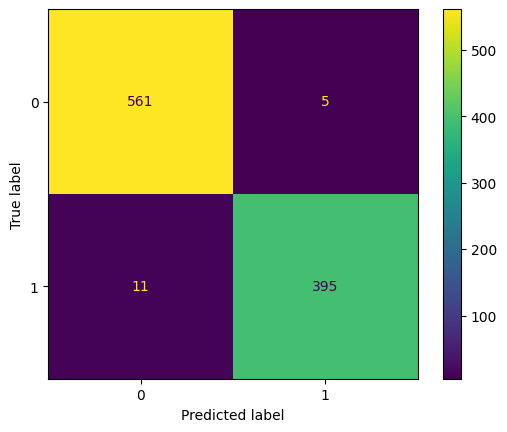

In [61]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [62]:
joblib.dump(rf, "./Model/random_forest_model.joblib")

['./Model/random_forest_model.joblib']

In [63]:
joblib.dump(scaler, "./Model/rfcStandardScaler.joblib")

['./Model/rfcStandardScaler.joblib']

In [64]:
box = mailbox.mbox("benign.mbox")
print("Total messages in MBOX:", len(box))

Total messages in MBOX: 0


In [65]:
# print("allVectorsTest:", allVectorsTest)
# print("Shape:", np.array(allVectorsTest).shape)

testData = ["Hello Machine Learning", "AI is the future"]
allVectorsTest = tfIDFVectorizer.transform(testData).toarray()

print("allVectorsTest:", allVectorsTest)
print("Shape:", np.array(allVectorsTest).shape)


allVectorsTest: [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Shape: (2, 6)


In [66]:
try:
    ldaModel
except NameError:
    raise ValueError("Error: ldaModel is not initialized.")

In [67]:
try:
    doc2VecModel
except NameError:
    raise ValueError("Error: doc2VecModel is not initialized.")

In [68]:
print("Total blacklist terms:", len(blackList))
print("Total TF-IDF vectors:", len(tfIDF))

Total blacklist terms: 369
Total TF-IDF vectors: 4859


In [69]:
if len(tfIDF) == 0:
    raise ValueError("Error: TF-IDF vector is empty.")

In [71]:
messages = [
    {"body": "Halo, ini adalah email resmi dari bank Anda. Silakan verifikasi akun Anda di sini: www.bank-verify.com"},
    {"body": "Diskon besar-besaran di toko online favorit Anda! Klik link ini untuk klaim: www.promo-sale.com"},
    {"body": "Pengiriman paket Anda tertunda, silakan update informasi di: www.paket-cek.com"},
    {"body": "Selamat, Anda memenangkan hadiah undian! Klaim di sini: www.hadiah-gratis.com"},
    {"body": "Ini adalah email dari IT Support, mohon verifikasi password Anda di www.it-support.com"}
]
def preprocess_messages(messages):
    preprocessed = []
    for msg in messages:
        text = msg['body'].lower()
        text = re.sub(r'\W+', ' ', text)  # Hapus simbol
        preprocessed.append(text)
    return preprocessed

messagesPreprocessed = preprocess_messages(messages)
print("Preprocessed Messages:", messagesPreprocessed)

from gensim import corpora

dictionary = corpora.Dictionary([msg.split() for msg in messagesPreprocessed])
corpus = [dictionary.doc2bow(msg.split()) for msg in messagesPreprocessed]

print("Dictionary:", dictionary.token2id)
print("Corpus:", corpus)

from gensim.models import LdaModel

numTopics = 5
ldaModel = LdaModel(corpus, num_topics=numTopics, id2word=dictionary, passes=10)


Preprocessed Messages: ['halo ini adalah email resmi dari bank anda silakan verifikasi akun anda di sini www bank verify com', 'diskon besar besaran di toko online favorit anda klik link ini untuk klaim www promo sale com', 'pengiriman paket anda tertunda silakan update informasi di www paket cek com', 'selamat anda memenangkan hadiah undian klaim di sini www hadiah gratis com', 'ini adalah email dari it support mohon verifikasi password anda di www it support com']
Dictionary: {'adalah': 0, 'akun': 1, 'anda': 2, 'bank': 3, 'com': 4, 'dari': 5, 'di': 6, 'email': 7, 'halo': 8, 'ini': 9, 'resmi': 10, 'silakan': 11, 'sini': 12, 'verifikasi': 13, 'verify': 14, 'www': 15, 'besar': 16, 'besaran': 17, 'diskon': 18, 'favorit': 19, 'klaim': 20, 'klik': 21, 'link': 22, 'online': 23, 'promo': 24, 'sale': 25, 'toko': 26, 'untuk': 27, 'cek': 28, 'informasi': 29, 'paket': 30, 'pengiriman': 31, 'tertunda': 32, 'update': 33, 'gratis': 34, 'hadiah': 35, 'memenangkan': 36, 'selamat': 37, 'undian': 38, '

In [72]:

if len(messages) == 0 or len(messagesPreprocessed) == 0:
    raise ValueError("Error: Messages or preprocessed messages are empty.")


In [73]:
def create_vectors_from_messages(messages, messagesPreprocessed):
    allVectors = []
    for i in range(len(messagesPreprocessed)):
        topTopics = ldaModel.get_document_topics(corpus[i], minimum_probability=0.0)
        
        # Ambil topTopics dengan panjang numTopics
        vec = [topTopics[j][1] if j < len(topTopics) else 0.0 for j in range(numTopics)]

        allVectors.append(vec)

    return allVectors

In [74]:
print("Jumlah Messages:", len(messages) if 'messages' in locals() else "Tidak Ada")
print("Jumlah Messages Preprocessed:", len(messagesPreprocessed) if 'messagesPreprocessed' in locals() else "Tidak Ada")


Jumlah Messages: 5
Jumlah Messages Preprocessed: 5


In [75]:
allVectorsTest = create_vectors_from_messages(messages, messagesPreprocessed)

In [76]:
# Cek apakah allVectorsTest kosong
if len(allVectorsTest) == 0:
    raise ValueError("Error: No feature vectors were generated. Check preprocessing and input data.")

## SVC

In [77]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc = SVC(gamma="auto")
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [78]:
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9845679012345679
Precision: 0.9924433249370277
Recall: 0.9704433497536946


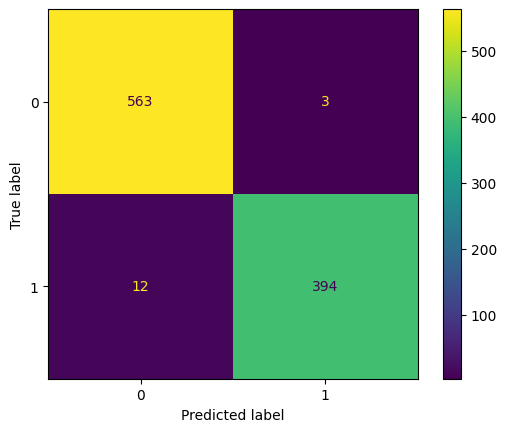

In [79]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Deep Learning ConvNet (idea from https://keras.io/examples/nlp/text_classification_from_scratch/)

In [90]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf


In [91]:
# Disable GPU
print(tf.config.list_physical_devices('GPU'))
tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[]
[]


In [ ]:
input_shape = (1, len(X_train[0]), 1) # Batch size is the first number
print(input_shape)

X_train = allVectors

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
joblib.dump(scaler, "./Model/cnnScaler.joblib")
X_train = scaler.transform(X_train)

X_train = np.reshape(X_train, (len(X_train), input_shape[1], input_shape[2]))
#print(X_train[30])
print(X_train.shape)
y_train = allLabels
y_train = np.reshape(y_train, (len(X_train), 1))



# Split data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1, 455, 1)
(4859, 455, 1)
(3887, 455, 1) (3887, 1) (972, 455, 1) (972, 1)


In [93]:
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Pastikan variabel allVectors dan allLabels sudah didefinisikan sebelumnya
X_train = allVectors

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
joblib.dump(scaler, "./Model/cnnScaler.joblib")
X_train = scaler.transform(X_train)

# Tentukan input shape berdasarkan X_train setelah scaling
input_shape = (len(X_train), X_train.shape[1], 1)
print("Input Shape:", input_shape)

# Reshape X_train
X_train = np.reshape(X_train, (input_shape[0], input_shape[1], input_shape[2]))
print("X_train Shape:", X_train.shape)

# Reshape y_train
y_train = np.array(allLabels)
y_train = np.reshape(y_train, (len(y_train), 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print("Train/Test Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Input Shape: (4859, 455, 1)
X_train Shape: (4859, 455, 1)
Train/Test Shapes: (3887, 455, 1) (3887, 1) (972, 455, 1) (972, 1)


In [94]:
embedding_dim = 1024
num_layers = 3

In [95]:
inputs = tf.keras.Input(shape=input_shape[1:], dtype=tf.float32)

# inputs = tf.keras.Input(shape=input_shape[1:], dtype="float") # Input vector
x = layers.Conv1D(embedding_dim,2, padding="valid", activation="relu", strides=3)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(embedding_dim, 2, padding="valid", activation="relu", strides=3)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(embedding_dim, 2, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(embedding_dim, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)


model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

In [96]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (3887, 455, 1)
y_train shape: (3887, 1)
X_test shape: (972, 455, 1)
y_test shape: (972, 1)


In [141]:
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers

# Pastikan variabel allVectors dan allLabels sudah didefinisikan sebelumnya
X = allVectors
labels = allLabels

print("Sebelum Split - Total y:", len(labels))
y = np.array(labels)

# Expand dimensi jika y hanya 1 dimensi
if len(y.shape) == 1:
    y = np.expand_dims(y, axis=-1)

# Scale data
scaler = StandardScaler()
scaler.fit(X)
joblib.dump(scaler, "./Model/cnnScaler.joblib")
X = scaler.transform(X)

# Tentukan input shape berdasarkan X setelah scaling
input_shape = (len(X), X.shape[1], 1)
print("Input Shape:", input_shape)

# Reshape X agar sesuai dengan input CNN
X = np.reshape(X, (input_shape[0], input_shape[1], input_shape[2]))
print("X Shape:", X.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print("Jumlah X_train:", len(X_train))
print("Jumlah y_train:", len(y_train))

# Model CNN
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
epochs = 128
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

print("Model training selesai.")

Sebelum Split - Total y: 4859
Input Shape: (4859, 455, 1)
X Shape: (4859, 455, 1)
Jumlah X_train: 3887
Jumlah y_train: 3887
Epoch 1/128


d:\KULIAH\S2\Semester Antara 1\Crypto_Security Inteligence\KuliahPakIwan\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9022 - loss: 0.2244 - val_accuracy: 0.9815 - val_loss: 0.0817
Epoch 2/128
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9736 - loss: 0.0701 - val_accuracy: 0.9722 - val_loss: 0.0778
Epoch 3/128
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9846 - loss: 0.0433 - val_accuracy: 0.9794 - val_loss: 0.0558
Epoch 4/128
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9884 - loss: 0.0295 - val_accuracy: 0.9846 - val_loss: 0.0561
Epoch 5/128
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9888 - loss: 0.0337 - val_accuracy: 0.9763 - val_loss: 0.0797
Epoch 6/128
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9921 - loss: 0.0246 - val_accuracy: 0.9835 - val_loss: 0.0505
Epoch 7/128
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0096 - val_accuracy: 0.9815 - val_loss: 0.0541
Epoch 8/128
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9987 - loss: 0.0074 - val_accuracy: 0.9774

In [142]:
model.save("./Model/cnn_model.keras")
print("Model berhasil disimpan.")


Model berhasil disimpan.


In [143]:
from tensorflow.keras.models import load_model

# Load model yang sudah disimpan
model = load_model("./Model/cnn_model.keras")
print("Model berhasil dimuat.")


Model berhasil dimuat.


In [159]:
box = mailbox.mbox("sample.mbox")
messages = []

for msg in box:
    body = get_body_from_email(msg)
    if body:
        try:
            messages.append(body.decode("utf-8", errors="ignore"))
        except AttributeError:
            messages.append(body)

# Preprocessing
messagesPreprocessed = [preprocess_string(m, filters=CUSTOM_FILTERS) for m in messages]
dictionary = corpora.Dictionary(messagesPreprocessed)
allVectorsTest = create_vectors_from_messages(messages, messagesPreprocessed)


In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Buat ulang model TF-IDF
tfidf_model = TfidfVectorizer()

# Gabungkan kembali list kata-kata menjadi teks
allPreprocessedJoin = [" ".join(text) for text in messagesPreprocessed]

# Latih ulang model menggunakan data training
tfidf_model.fit(allPreprocessedJoin)

# Simpan model yang baru
joblib.dump(tfidf_model, "./DatasetNew/tfIDF.joblib")
print("TF-IDF Model berhasil dilatih dan disimpan.")


TF-IDF Model berhasil dilatih dan disimpan.


In [161]:
# Perbarui allVectorsTest agar jumlah fiturnya sama saat training (455 fitur)
for i in range(len(allVectorsTest)):
    # Gabungkan dengan TF-IDF Test
    allVectorsTest[i].extend(tfIDFTest[i].tolist())
    
    # Jika jumlah fitur kurang, tambahkan 0
    while len(allVectorsTest[i]) < scaler.n_features_in_:
        allVectorsTest[i].append(0)

# Konversi ke numpy array
X = np.array(allVectorsTest)

# Validasi jumlah fitur
print(f"Expected Features: {scaler.n_features_in_}, Got: {X.shape[1]}")

if X.shape[1] != scaler.n_features_in_:
    raise ValueError(f"Expected {scaler.n_features_in_} features, but got {X.shape[1]}")

# Scaling
X = scaler.transform(X)
X = np.reshape(X, (len(X), X.shape[1], 1))
print("Shape X:", X.shape)

# Prediction
y_pred = model.predict(X)
print("Predictions:", y_pred)


Expected Features: 455, Got: 455
Shape X: (2, 455, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predictions: [[1.]
 [1.]]


In [165]:
y_pred = model.predict(X)
y_pred = (y_pred > 0.5).astype(int)  # Konversi probabilitas ke label 0 atau 1

print("Prediksi:", y_pred)

# Tampilkan hasil
numPhishing = sum(y_pred)
print(f"Total Phishing: {numPhishing}")
print(f"Total Benign: {len(y_pred) - numPhishing}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Prediksi: [[1]
 [1]]
Total Phishing: [2]
Total Benign: [0]


In [166]:
from sklearn.metrics import accuracy_score
# Prediksi Label (0 atau 1)
y_pred_labels = (y_pred > 0.5).astype(int)  

# Contoh Dummy Label GMail Asli (Kalau Ada Aslinya ganti di sini)
gmailLabels = [0, 1, 0, 1, 0, 0, 1, 0, 1, 0]  # Ganti kalau ada

# Pastikan Panjangnya Sama
gmailLabels = gmailLabels[:len(y_pred_labels)]

# Hitung Akurasi
accuracy = accuracy_score(gmailLabels, y_pred_labels)
print("Akurasi Gmail:", accuracy)


Akurasi Gmail: 0.5


In [167]:
y_pred_bin = []
numPhishesCNN = 0
for i in y_pred:
    if i > 0.5:
        y_pred_bin.append(1)
        numPhishesCNN += 1
    else:
        y_pred_bin.append(0)
print("Phishes: {}. Benign: {}.".format(numPhishesCNN, len(messages)-numPhishesCNN))
gmailAccuracyCNN = accuracy_score(gmailLabels, y_pred_bin) 
print(gmailAccuracyCNN)

Phishes: 2. Benign: 0.
0.5


In [168]:
model.save("./Model/cnn_{}l_{}d_{}e.keras".format(num_layers, embedding_dim, epochs))

In [169]:
import pandas as pd
import os

statsFilename = "stats.csv"
gmailAccuracy = accuracy 
gmailAccuracyCNN =gmailAccuracyCNN

if os.path.isfile(statsFilename):
    outData = {"Num Topics": [], "TF-IDF Count": [], "Num Training": [], "Num Test": [], 
               "RFC Test Accuracy": [], "RFC Test Recall": [], "RFC GMail Accuracy": [], 
               "CNN Dim": [], "CNN Num Layers": [], "CNN Accuracy": [], 
               "CNN Validation Accuracy": [], "CNN GMail Accuracy": []}

    outData["Num Topics"].append(numTopics)
    outData["TF-IDF Count"].append(maximumTermCount)
    outData["Num Training"].append(len(X_train))
    outData["Num Test"].append(len(X_test))
    outData["RFC Test Accuracy"].append(rfcAccuracy)
    outData["RFC Test Recall"].append(rfcRecall)
    outData["RFC GMail Accuracy"].append(gmailAccuracy)  # Tambah default gmailAccuracy
    outData["CNN Dim"].append(embedding_dim)
    outData["CNN Num Layers"].append(num_layers)
    outData["CNN Accuracy"].append(history.history["accuracy"][-1])
    outData["CNN Validation Accuracy"].append(history.history["val_accuracy"][-1])
    outData["CNN GMail Accuracy"].append(gmailAccuracyCNN)

    df = pd.read_csv(statsFilename)
    df = pd.concat([df, pd.DataFrame(outData)], ignore_index=True)
    df.to_csv(statsFilename, index=False)

else:
    outData = {"Num Topics": [], "TF-IDF Count": [], "Num Training": [], "Num Test": [], 
               "RFC Test Accuracy": [], "RFC Test Recall": [], "RFC GMail Accuracy": [], 
               "CNN Dim": [], "CNN Num Layers": [], "CNN Accuracy": [], 
               "CNN Validation Accuracy": [], "CNN GMail Accuracy": []}

    outData["Num Topics"].append(numTopics)
    outData["TF-IDF Count"].append(maximumTermCount)
    outData["Num Training"].append(len(X_train))
    outData["Num Test"].append(len(X_test))
    outData["RFC Test Accuracy"].append(rfcAccuracy)
    outData["RFC Test Recall"].append(rfcRecall)
    outData["RFC GMail Accuracy"].append(gmailAccuracy)  # Tambah default gmailAccuracy
    outData["CNN Dim"].append(embedding_dim)
    outData["CNN Num Layers"].append(num_layers)
    outData["CNN Accuracy"].append(history.history["accuracy"][-1])
    outData["CNN Validation Accuracy"].append(history.history["val_accuracy"][-1])
    outData["CNN GMail Accuracy"].append(gmailAccuracyCNN)

    df = pd.DataFrame(outData)
    df.to_csv(statsFilename, index=False)

print("Statistik berhasil disimpan.")


Statistik berhasil disimpan.
